### Clinical-Trial Survival Analysis for Treatment Efficacy
lifelines Python package is a library used for survival analysis.

In [ ]:
!pip install lifelines --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 7.1 MB/s eta 0:00:00


lifelines package: KaplanMeierFitter for non-parametric survival curves, CoxPHFitter for regression analysis on survival data, and logrank_test to statistically compare survival functions.

In [ ]:
# Import necessary libraries
from lifelines import KaplanMeierFitter,CoxPHFitter
from lifelines.statistics import logrank_test
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df=pd.read_csv('https://samatrix-data.s3.ap-south-1.amazonaws.com/Statistics-Project/veteran.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            274 non-null    int64 
 1   TIME          274 non-null    int64 
 2   Y             274 non-null    int64 
 3   trt           274 non-null    object
 4   celltype      274 non-null    object
 5   karno         274 non-null    int64 
 6   diagtime      274 non-null    int64 
 7   age           274 non-null    int64 
 8   priortherapy  274 non-null    object
dtypes: int64(6), object(3)
memory usage: 19.4+ KB


In [ ]:
df.head()

,ID,TIME,Y,trt,celltype,karno,diagtime,age,priortherapy
0,1,0,0,standard,squamous,60,7,69,no
1,1,72,1,standard,squamous,60,7,69,no
2,2,0,0,standard,squamous,70,5,64,yes
3,2,411,1,standard,squamous,70,5,64,yes
4,3,0,0,standard,squamous,60,3,38,no


## Kaplan-Meier Method

The Kaplan-Meier method shows how long people stay free from an event (like death) over time. It creates a step-like survival curve and can handle cases where some people drop out or don’t experience the event. It’s useful for comparing treatments.

The `KaplanMeierFitter` is used to build this survival model. It filters the data to include only patients with `Y == 1`, fits the model using time and status, and then plots the survival curve.


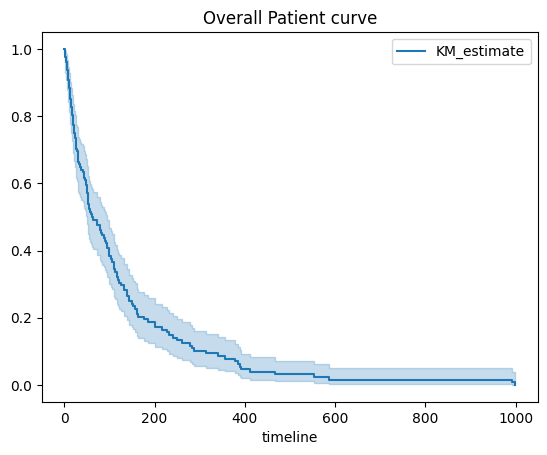

In [ ]:
kmf=KaplanMeierFitter()
#separate your event(y=1 or y=0)
df_event=df[df['Y']==1]

#for overall patient curve
kmf.fit(durations=df_event['TIME'],event_observed=df_event['Y'])
kmf.plot_survival_function()
plt.title('Overall Patient curve')
plt.show()

This compares survival curves for different treatment groups. It loops through each unique treatment, filters the data for that group, fits a Kaplan-Meier curve, and plots them together. This helps visually compare how effective each treatment is over time.

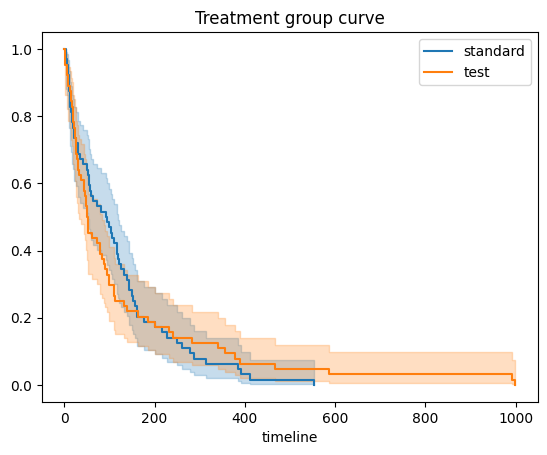

In [ ]:
#curve according to treatment group
for trt_group in df_event['trt'].unique():
  mask=df_event['trt']==trt_group
  kmf.fit(df_event[mask]['TIME'],df_event[mask]['Y'],label=trt_group)
  kmf.plot_survival_function()
plt.title('Treatment group curve')
plt.show()

## Median Survival Time

The median survival time is the time at which half the patients have experienced the event (e.g., death). It’s taken from the Kaplan-Meier curve and shows how long patients typically stay event-free. A longer median survival time means better treatment effectiveness.

The code calculates and prints the median survival time for each treatment group by fitting a Kaplan-Meier model to each group and retrieving the median time from the model.


In [ ]:
for trt_group in df_event['trt'].unique():
  mask=df_event['trt']==trt_group
  kmf.fit(df_event[mask]['TIME'],df_event[mask]['Y'],label=str(trt_group)+'median='+str(np.median(df_event[mask]['TIME'])))
  print(f"Median survival time for {trt_group} is {np.median(df_event[mask]['TIME'])}")

Median survival time for standard is 93.5
Median survival time for test is 51.5


## Log-Rank Test

The log-rank test compares survival times between groups, like different treatments, to see if there's a real difference in outcomes. A small p-value means the difference is significant, helping to identify the better treatment.

In this case, the log-rank test compares two groups: **"standard"** and **"test"**. It filters the data for each group and uses the `logrank_test()` function. The results, including the p-value, are printed to show if the survival difference between treatments is statistically meaningful.

In [ ]:
from lifelines.statistics import logrank_test
group1=df_event[df_event['trt']=='standard']
group2=df_event[df_event['trt']=='test']
results=logrank_test(group1['TIME'],group2['TIME'],event_observed_A=group1['Y'],event_observed_B=group2['Y'])
print(results.summary)

   test_statistic        p  -log2(p)
0          0.0116  0.91423  0.129371


## Cox Proportional Hazards model

The Cox Proportional Hazards Model is a popular method in survival analysis used to study how multiple factors affect survival time.

To prepare for Cox regression, the data is first filtered and copied. Then, categorical variables like **treatment (trt)**, **cell type**, and **prior therapy** are converted into dummy variables using encoding. This step is essential because regression models require numeric input.

In [ ]:
from lifelines import CoxPHFitter
#prepare wide-formate data: one row per subject
df_wide=df_event.copy()
#Encode categorical variables
df_wide=pd.get_dummies(df_wide,columns=['trt','celltype','priortherapy'],drop_first=True)

Now, the Cox Proportional Hazards model is fitted using the prepared data. It uses **TIME** as the duration and **Y** as the event indicator. After training, the model prints a summary showing hazard ratios and the significance of each variable. Finally, it uses `plot()` to visualize the hazard ratios—values >1 mean higher risk, while values <1 mean lower risk of the event.

<lifelines.CoxPHFitter: fitted with 128 total observations, 0 right-censored observations>
             duration col = 'TIME'
                event col = 'Y'
      baseline estimation = breslow
   number of observations = 128
number of events observed = 128
   partial log-likelihood = -465.21
         time fit was run = 2025-05-30 04:38:17 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
ID                  0.00      1.00      0.01           -0.03            0.03                0.97                1.03
karno              -0.03      0.97      0.01           -0.05           -0.02                0.96                0.98
diagtime           -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
age                -0.01      0.99      0.01           -0.03            0.00                0.97                1.00
trt_test            0.16      1.17      1.02           -1.84            2.16                0.16                8.63
celltype_large     -0.83      0.43      0.36           -1.53           -0.14                0.22                0.87
celltype_smallcell -0.12      0.88      0.38           -0.88            0.63                0.42                1.88
celltype_squamous  -0.97      0.38      0.66           -2.27            0.33                0.10                1.38
priortherapy_yes    0.18      1.20      0.24           -0.28            0.65                0.76                1.91

                    cmp to     z      p  -log2(p)
covariate                                        
ID                    0.00  0.20   0.84      0.25
karno                 0.00 -6.08 <0.005     29.60
diagtime              0.00 -0.47   0.63      0.66
age                   0.00 -1.54   0.12      3.02
trt_test              0.00  0.16   0.88      0.19
celltype_large        0.00 -2.34   0.02      5.71
celltype_smallcell    0.00 -0.32   0.75      0.42
celltype_squamous     0.00 -1.47   0.14      2.82
priortherapy_yes      0.00  0.79   0.43      1.21
---
Concordance = 0.74
Partial AIC = 948.43
log-likelihood ratio test = 62.38 on 9 df
-log2(p) of ll-ratio test = 31.00

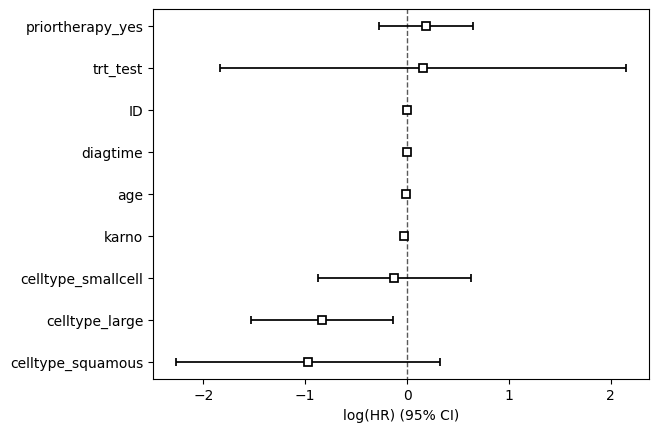

In [ ]:
cph=CoxPHFitter()
cph.fit(df_wide,duration_col='TIME',event_col='Y')
cph.print_summary()
cph.plot()
plt.show()
#if hazard score is >1 then higher risk and <1 less risk

### time varying survival analysis

Time-varying survival analysis is used when factors like treatment or health status change over time. It gives a more accurate view of how these changes impact survival.

The code splits the data into start and event records, renames columns to show time intervals (`start`, `stop`), and merges them by patient ID. Then it encodes categorical variables and shows a preview of the main columns for analysis.

In [ ]:
#step 1 seprate rows
df_start=df[df["Y"]==0].copy()
df_event=df[df["Y"]==1].copy()

#merge & change column name
df_event=df_event.rename(columns={"TIME":"stop","Y":"event"})
df_start=df_start.rename(columns={"TIME":"start"})

df_timevarying=pd.merge(df_start,df_event[["ID","stop","event"]],on="ID")

# one-hot encoding
df_timevarying = pd.get_dummies(df_timevarying, columns=['trt','celltype' ,'priortherapy'], drop_first=True)

# Final check
print(df_timevarying[['ID', 'start', 'stop', 'event']].head())

   ID  start  stop  event
0   1      0    72      1
1   2      0   411      1
2   3      0   228      1
3   4      0   126      1
4   5      0   118      1


In [ ]:
#check there is null value
print(df_timevarying.isnull().sum())
#ensure y is not in the modeling data
if 'Y' in df_timevarying.columns:
   df_timevarying.drop(columns=['Y'],inplace=True)

ID                    0
start                 0
Y                     0
karno                 0
diagtime              0
age                   0
stop                  0
event                 0
trt_test              0
celltype_large        0
celltype_smallcell    0
celltype_squamous     0
priortherapy_yes      0
dtype: int64


## cox time-varying coefficient



The Cox Time-Varying Coefficient Model helps analyze how the effects of variables change over time.

It uses `CoxTimeVaryingFitter` to fit the model with patient ID, event status, and time intervals (`start`, `stop`). After fitting, it shows the model summary and plots the coefficients to understand how the impact of each variable changes during the observation period.

<lifelines.CoxTimeVaryingFitter: fitted with 128 periods, 128 subjects, 128 events>
         event col = 'event'
number of subjects = 128
 number of periods = 128
  number of events = 128
partial log-likelihood = -465.24
  time fit was run = 2025-05-30 04:38:18 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
karno              -0.03      0.97      0.01           -0.05           -0.02                0.96                0.98
diagtime           -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
age                -0.01      0.99      0.01           -0.03            0.00                0.97                1.00
trt_test            0.36      1.44      0.21           -0.05            0.77                0.95                2.17
celltype_large     -0.80      0.45      0.30           -1.38           -0.21                0.25                0.81
celltype_smallcell -0.18      0.84      0.28           -0.72            0.36                0.49                1.44
celltype_squamous  -1.10      0.33      0.30           -1.68           -0.51                0.19                0.60
priortherapy_yes    0.18      1.19      0.23           -0.28            0.63                0.76                1.88

                    cmp to     z      p  -log2(p)
covariate                                        
karno                 0.00 -6.07 <0.005     29.52
diagtime              0.00 -0.45   0.65      0.61
age                   0.00 -1.53   0.12      3.00
trt_test              0.00  1.72   0.08      3.56
celltype_large        0.00 -2.65   0.01      6.95
celltype_smallcell    0.00 -0.65   0.52      0.96
celltype_squamous     0.00 -3.66 <0.005     11.94
priortherapy_yes      0.00  0.76   0.45      1.17
---
Partial AIC = 946.47
log-likelihood ratio test = 62.34 on 8 df
-log2(p) of ll-ratio test = 32.53

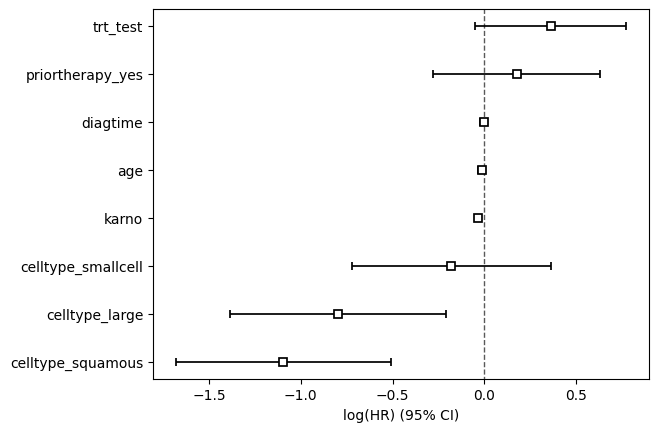

In [ ]:
from lifelines import CoxTimeVaryingFitter
ctv=CoxTimeVaryingFitter()
ctv.fit(df_timevarying,id_col='ID',event_col='event',start_col='start',stop_col='stop')
ctv.print_summary()
ctv.plot()
plt.show()

### Kaplin-Meier Time varying
This creates Kaplan-Meier survival curves to compare survival rates across different cell types.

For each unique cell type, it filters the data, fits a Kaplan-Meier model using **TIME** (duration) and **Y** (event status), and plots the survival curves. The graph shows how survival probabilities change over time for each cell type, helping to see which types are linked to better or worse outcomes.


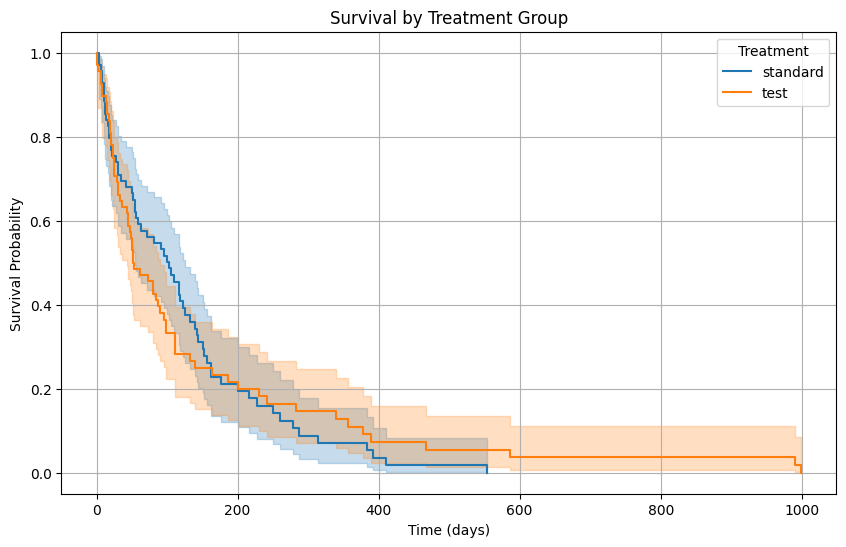

In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))

for group in df['trt']. unique():
  label = str(group)
  mask = df['trt'] == group
  kmf. fit(df[mask] ['TIME' ], event_observed=df[mask] ['Y'], label=label)
  kmf.plot_survival_function()

plt.title('Survival by Treatment Group')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend(title="Treatment")
plt.show()

In [ ]:
print(df['trt'].value_counts())

trt
standard    138
test        136
Name: count, dtype: int64


In [ ]:
from lifelines.statistics import logrank_test

# Assuming 'trt' column has two treatment types (e.g., 1 = Standard, 2 = Test)
group1 = df[df['trt' ] == 'standard']
group2 = df[df['trt' ] == 'test']

# Perform the log-rank test using correct event column: 'Y'
results = logrank_test(
group1[ 'TIME'], group2[ 'TIME' ],
event_observed_A=group1[ 'Y'],
event_observed_B=group2['Y' ])

# Output
print(f"Log-Rank Test p-value: {results.p_value :. 4f}")

if results.p_value < 0.05:
  print(" Significant difference in survival.")
else:
  print(" No statistically significant difference.")

ValueError: Format specifier missing precision